## sigMF STFT on GPU and CPU

In [1]:
import os
import itertools
from sklearn.utils import shuffle
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as d
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.modules as mod
import torch.utils.data
import torch.utils.data as data
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
from torch.autograd import Variable
import numpy as np
import sys
import importlib
import time
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
import librosa
from scipy import signal
from scipy import stats
from scipy.special import comb
import matplotlib.pyplot as plt
import glob
import json
import pickle
from random import randint, choice
import random
from timeit import default_timer as timer
from torchaudio.functional import istft
from sklearn.decomposition import NMF
plt.style.use('default')
device = torch.device('cuda:0')
print('Torch version =', torch.__version__, 'CUDA version =', torch.version.cuda)
print('CUDA Device:', device)
print('Is cuda available? =',torch.cuda.is_available())

/home/david/.local/lib/python3.6/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


Torch version = 1.6.0 CUDA version = 10.2
CUDA Device: cuda:0
Is cuda available? = True


In [2]:
# %matplotlib notebook
# %matplotlib inline

#### Machine paths

In [3]:
# path = "/home/db/sigMF_ML/class3/data_voice/" # G7
# path_val = "/home/db/sigMF_ML/class3/val_data2/" # G7
# path_save = "/home/db/sigMF_ML/class3/" # G7
# path_doc = "/home/db/sigMF_ML/class3/data_dump2/" # G7
# path_temp = "/home/db/sigMF_ML/class3/temp2/" # G7

# path = "/home/david/sigMF_ML/class2/data2/" # GTX1080Ti

# path_save = "/home/david/sigMF_ML/class2/" # GTX1080Ti
# path_temp = "/home/david/sigMF_ML/class2/temp2/"  # GTX1080Ti
# path_val = "/home/david/sigMF_ML/class2/val_data2/" # GTX1080Ti
# path_doc = "/home/david/sigMF_ML/class2/data_dump2/" # GTX1080Ti
# path = "/home/david/sigMF_ML/class2/data_voice/" # GTX1080Ti

# path = "/home/david/sigMF_ML/class2/E503 project/" # ace
# path_val = "/home/david/sigMF_ML/class2/val_data2/" # ace
path_save = "/home/david/sigMF_ML/class2/UDV_matrix/" # ace
# path_doc = "/home/david/sigMF_ML/class2/data_dump2/" # ace
# path_temp = "/home/david/sigMF_ML/class2/temp2/" # ace
path = "/home/david/sigMF_ML/class2/clean_speech/IQ_files/" # ace

# path = "/home/david/sigMF_ML2/class3/data/" # tensorbook
# path_val = "/home/david/sigMF_ML2/class3/val_data/" # tensorbook
# path_save = "/home/david/sigMF_ML2/class3/" # tensorbook
# path_doc = "/home/david/sigMF_ML2/class3/data_dump/" # tensorbook
# path_temp = "/home/david/sigMF_ML2/class3/temp/" # tensorbook
# path = "/home/david/sigMF_ML2/class3/data2/" # tensorbook
# path_val = "/home/david/sigMF_ML2/class3/val_data/" # tensorbook
# path_save = "/home/david/sigMF_ML2/class3/" # tensorbook
# path_doc = "/home/david/sigMF_ML2/class3/data_dump/" # tensorbook
# path_temp = "/home/david/sigMF_ML2/class3/temp/" # tensorbook
# path = "/home/david/sigMF_ML2/class3/data_voice/" # tensorbook

#path = "/content/" # colab
print(path)

/home/david/sigMF_ML/class2/clean_speech/IQ_files/


#### reading sigmf meta data and encoder function

In [4]:
# START OF FUNCTIONS ****************************************************
def meta_encoder(meta_list, num_classes): 
    a = np.asarray(meta_list, dtype=int)
#    print('a = ', a)
    return a 

def read_meta(meta_files):
    meta_list = []
    for meta in meta_files:
        all_meta_data = json.load(open(meta))
        meta_list.append(all_meta_data['global']["core:class"])
    meta_list = list(map(int, meta_list))
    return meta_list

def read_num_val(x):
    x = len(meta_list_val)
    return x

In [5]:
print(path)
os.chdir(path)
data_files = sorted(glob.glob('*.sigmf-data'))
meta_files = sorted(glob.glob('*.sigmf-meta'))

/home/david/sigMF_ML/class2/clean_speech/IQ_files/


In [6]:
for meta in meta_files:
    all_meta_data = json.load(open(meta))
    print("file name = ", meta)

file name =  UHF_DMR_clean1.sigmf-meta


#### torch GPU Cuda stft

In [7]:
def gpu(db, n_fft):
    I = db[0::2]
    Q = db[1::2]
    start = timer()
    w = 512
    win = torch.hann_window(w, periodic=True, dtype=None, layout=torch.strided, requires_grad=False)
    I_stft = torch.stft(torch.tensor(I).cuda(), n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    Q_stft = torch.stft(torch.tensor(Q).cuda(), n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    X_stft = I_stft[...,0] + Q_stft[...,0] + I_stft[...,1] + -1*Q_stft[...,1]
    X_stft = torch.cat((X_stft[n_fft//2:],X_stft[:n_fft//2]))
    end = timer()
    print(end - start)
    torch.cuda.empty_cache()
    return X_stft, I_stft, Q_stft

#### scipy CPU stft function

In [8]:
def cpu(db, n_fft):
    t = len(db)
    db2 = db[0::]
    start = timer()
    db = db.astype(np.float32).view(np.complex64)
    Fs = 1e6
    I_t, I_f, Z = signal.stft(db, fs=Fs, nperseg=n_fft, return_onesided=False)
    Z = np.vstack([Z[n_fft//2:], Z[:n_fft//2]])
    end = timer()
    print(end - start)
    return Z

### GPU Timing

In [15]:
n_fft = 1024
for file in data_files:
    db = np.fromfile(file, dtype="float32")
    stft_gpu, I_stft, Q_stft = gpu(db, n_fft)

0.09270772300078534


In [16]:
I_stft.shape, Q_stft.shape, stft_gpu.shape

(torch.Size([1024, 29297, 2]),
 torch.Size([1024, 29297, 2]),
 torch.Size([1024, 29297]))

In [17]:
Q_stft[497:504, 1, 0],Q_stft[497:504, 1, 1]

(tensor([ 2.7195e-06, -2.2085e-07, -3.6999e-06,  8.1809e-06, -1.1165e-05,
          1.1195e-05, -8.6057e-06], device='cuda:0'),
 tensor([ 1.3284e-05, -1.9587e-05,  2.1619e-05, -1.8408e-05,  1.2709e-05,
         -8.2676e-06,  6.6279e-06], device='cuda:0'))

In [18]:
I_stft[497:504, 1, 0],I_stft[497:504, 1, 1]

(tensor([-1.0865e-05,  8.6170e-06, -4.1730e-06,  8.2917e-07, -6.5658e-08,
          3.8847e-07,  6.2009e-07], device='cuda:0'),
 tensor([-5.0840e-07,  3.1674e-07, -3.2491e-06,  7.9339e-06, -1.1156e-05,
          1.0786e-05, -7.8057e-06], device='cuda:0'))

In [19]:
stft_gpu[497:504, 1]

tensor([ 0.0003,  0.0003, -0.0005, -0.0005,  0.0009,  0.0006, -0.0014],
       device='cuda:0')

In [20]:
stft_gpu.shape

torch.Size([1024, 29297])

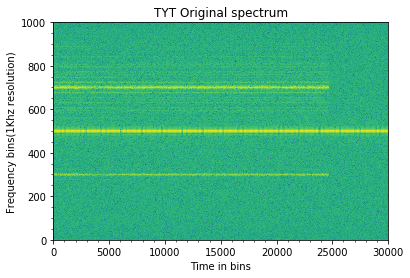

In [26]:
plt.figure(figsize=(9, 6))
fig3 = plt.figure()
plt.imshow(20*np.log10(np.abs(stft_gpu.cpu()+1e-8)), aspect='auto', origin='lower')
title = "TYT Original spectrum"
plt.title(title)
plt.xlabel('Time in bins')
plt.ylabel('Frequency bins(1Khz resolution)')
plt.minorticks_on()
# plt.yticks(np.arange(0,60, 6))
fig3.savefig('tyt_full_spectrum.pdf', format="pdf")
plt.show()

### CPU Timing

In [17]:
# for file in data_files:
#     db = np.fromfile(file, dtype="float32")
#     stft_cpu = cpu(db, 1000)

In [18]:
# stft_cpu.shape

In [19]:
np.abs(stft_gpu.detach().cpu().numpy()[497:504, 1])

array([0.11576539, 0.28129935, 0.42185238, 0.44148278, 0.3258681 ,
       0.15635614, 0.03228373], dtype=float32)

In [21]:
# np.abs(stft_cpu[497:504, 1])

### CPU load stft to Cuda Time

In [22]:
# start = timer()
# IQ_tensor = torch.tensor(np.abs(stft_cpu)).cuda()
# end = timer()
# print(end - start)
# torch.cuda.empty_cache()

In [23]:
# plt.imshow(20*np.log10(np.abs(stft_cpu)+1e-8), aspect='auto', origin='lower')
# plt.show()

#### GPU SVD

In [21]:
def udv_stft(I_stft,Q_stft):
    start = timer()
    U_I0, D_I0, V_I0 = torch.svd(I_stft[...,0]) 
    U_I1, D_I1, V_I1 = torch.svd(I_stft[...,1]) 
    U_Q0, D_Q0, V_Q0 = torch.svd(Q_stft[...,0]) 
    U_Q1, D_Q1, V_Q1 = torch.svd(Q_stft[...,1]) 
    end = timer()
    print('SVD time: ',end - start)
    return U_I0, D_I0, V_I0, U_I1, D_I1, V_I1, U_Q0, D_Q0, V_Q0, U_Q1, D_Q1, V_Q1

#### Inverse stft 

In [28]:
def ISTFT(db, n_fft):# We are matching scipy.signal behavior (setting noverlap=frame_length - hop) 
    w = 1024
    win = torch.hann_window(w, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda()
    start = timer()
    Z = istft(db, n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    end = timer()
    print('ISTFT time = ',end - start)
    torch.cuda.empty_cache()
    return Z

#### Re-combine UDV to approximate original signal

In [23]:
def udv(u, d, v, k): # like ----> np.matrix(U[:, :k]) * np.diag(D[:k]) * V[:k, :]
    start = timer()
    UD = torch.mul(u[:, :k], d[:k])
    v = torch.transpose(v,1,0)
    UDV = torch.mm(UD, v[:k, :])
    end = timer()
    print('UDV time: ',end - start)
    return UDV

In [24]:
print(path_save)
os.chdir(path_save)

/home/david/sigMF_ML/class2/UDV_matrix/


In [25]:
np.save('I_stft', I_stft.detach().cpu().numpy())
np.save('Q_stft', Q_stft.detach().cpu().numpy())

### Main function to run all sub function calls

In [26]:
def complete(I_stft,Q_stft, num, n_fft):
    U_I0, D_I0, V_I0, U_I1, D_I1, V_I1, U_Q0, D_Q0, V_Q0, U_Q1, D_Q1, V_Q1 = udv_stft(I_stft,Q_stft)
    torch.cuda.empty_cache()
    print('UDV I0 shapes = ',U_I0.shape, D_I0.shape, V_I0.shape)
    print('UDV I1 shapes = ',U_I1.shape, D_I1.shape, V_I1.shape)
    print('UDV Q0 shapes = ', U_Q0.shape, D_Q0.shape, V_Q0.shape)
    print('UDV Q1 shapes = ', U_Q1.shape, D_Q1.shape, V_Q1.shape)
    # ------------ I0 ------------------------------------------------------
    np.save('U_I0', U_I0[:, :num].detach().cpu().numpy())
    np.save('D_I0', D_I0[:num].detach().cpu().numpy())
    np.save('V_I0', V_I0[:num, :].detach().cpu().numpy())
    # ------------ I1 ------------------------------------------------------
    np.save('U_I1', U_I1[:, :num].detach().cpu().numpy())
    np.save('D_I1', D_I1[:num].detach().cpu().numpy())
    np.save('V_I1', V_I1[:num, :].detach().cpu().numpy())
    # ------------ Q0 ------------------------------------------------------
    np.save('U_Q0', U_Q0[:, :num].detach().cpu().numpy())
    np.save('D_Q0', D_Q0[:num].detach().cpu().numpy())
    np.save('V_Q0', V_Q0[:num, :].detach().cpu().numpy()) 
    # ------------ Q1 ------------------------------------------------------
    np.save('U_Q1', U_Q1[:, :num].detach().cpu().numpy())
    np.save('D_Q1', D_Q1[:num].detach().cpu().numpy())
    np.save('V_Q1', V_Q1[:num, :].detach().cpu().numpy())    
    # -----------------------------------------------------------------------
    udv_I0 = udv(U_I0, D_I0, V_I0,num)
    udv_I1 = udv(U_I1, D_I1, V_I1,num)
    udv_Q0 = udv(U_Q0, D_Q0, V_Q0,num)
    udv_Q1 = udv(U_Q1, D_Q1, V_Q1,num)
    torch.cuda.empty_cache()
    print('udv I shapes = ',udv_I0.shape,udv_I1.shape)
    print('udv Q shapes = ',udv_Q0.shape,udv_Q1.shape)
    # -------------stack and transpose----------------------------------------
    UDV_I = torch.stack([udv_I0,udv_I1])
    UDV_I = torch.transpose(UDV_I,2,0)
    UDV_I = torch.transpose(UDV_I,1,0)
    UDV_Q = torch.stack([udv_Q0,udv_Q1])
    UDV_Q = torch.transpose(UDV_Q,2,0)
    UDV_Q = torch.transpose(UDV_Q,1,0)
    torch.cuda.empty_cache()
    #--------------------------------------------------------------------------
    I = ISTFT(UDV_I, n_fft)
    Q = ISTFT(UDV_Q, n_fft)
    torch.cuda.empty_cache()
    I = I.detach().cpu().numpy()
    Q = Q.detach().cpu().numpy()
    end = len(I)*2
    IQ_SVD = np.zeros(len(I)*2)
    IQ_SVD[0:end:2] = I
    IQ_SVD[1:end:2] = Q 
    IQ_SVD = IQ_SVD.astype(np.float32).view(np.complex64)
    return IQ_SVD

### Perform SVD on IQ stft data

In [31]:
num = 2 # number to reconstruct SVD matrix from
IQ_SVD = complete(I_stft,Q_stft, num, n_fft)

SVD time:  9.4943200800044
UDV I0 shapes =  torch.Size([1024, 1024]) torch.Size([1024]) torch.Size([29297, 1024])
UDV I1 shapes =  torch.Size([1024, 1024]) torch.Size([1024]) torch.Size([29297, 1024])
UDV Q0 shapes =  torch.Size([1024, 1024]) torch.Size([1024]) torch.Size([29297, 1024])
UDV Q1 shapes =  torch.Size([1024, 1024]) torch.Size([1024]) torch.Size([29297, 1024])
UDV time:  0.0015169789840001613
UDV time:  0.0009519640007056296
UDV time:  0.0009790859767235816
UDV time:  0.0009920260054059327
udv I shapes =  torch.Size([1024, 29297]) torch.Size([1024, 29297])
udv Q shapes =  torch.Size([1024, 29297]) torch.Size([1024, 29297])
ISTFT time =  0.009022055979585275
ISTFT time =  0.009689449012512341


### Write reconstructed IQ file to file

In [32]:
from array import array
IQ_file = open("tyt_clean_svd2_20210517", 'wb')
IQ_SVD.tofile(IQ_file)
IQ_file.close()